In addition to the packages below, this script requires fsl to be installed on computer...

In [15]:
%%capture
import numpy as np
from scipy import ndimage, stats, ndimage
import matplotlib.pyplot as plt
from nilearn import plotting, image, input_data
from nilearn.image import load_img, index_img, new_img_like, resample_to_img, threshold_img
from nilearn.input_data import NiftiMasker
from scipy.stats import norm
import timeit
import seaborn as sns
import pandas as pd
from lmfit.models import SkewedGaussianModel
from nipype.interfaces.fsl.model import SmoothEstimate

In [16]:
import nilearn
import nibabel
import nipype
print(nilearn.__version__)
print(nibabel.__version__)
print(nipype.__version__)

0.6.0b
2.5.1
1.4.2


In [3]:
# use nipype's interface to the FSL smoothest command
est = SmoothEstimate()
smoothing_values = [];
for i in range(1,21):
    if i < 10:
        est.inputs.zstat_file = 'data/FUNCTIONAL_ICA_BRAINMAP_0' + str(i) + '.nii.gz'
    else: 
        est.inputs.zstat_file = 'data/FUNCTIONAL_ICA_BRAINMAP_' + str(i) + '.nii.gz'
        
    est.inputs.mask_file = 'data/colin_27_mask_2mm_dil.nii.gz'
    est.terminal_output = 'file_split'
    smoothest_output = est.run()
    smoothing_values.append(float(smoothest_output.runtime.stdout.split(" ")[4]))
    smoothing_values.append(float(smoothest_output.runtime.stdout.split(" ")[5]))
    smoothing_values.append(float(smoothest_output.runtime.stdout.split(" ")[6][0:6]))
    
print("Functional Smoothing Mean Estimate (FWHMxyz voxels): " + str(np.mean(np.array(smoothing_values))))
print("Functional Smoothing Median Estimate (FWHMxyz voxels): " + str(np.median(np.array(smoothing_values))))
func_mean = np.mean(np.array(smoothing_values))

Functional Smoothing Mean Estimate (FWHMxyz voxels): 10.003091666666668
Functional Smoothing Median Estimate (FWHMxyz voxels): 9.96062


Load functional/vbm components and estimate their smoothness

In [4]:
# use nipype's interface to the FSL smoothest command
est = SmoothEstimate()
smoothing_values = [];
for i in range(1,21):
    if i < 10:
        est.inputs.zstat_file = 'data/VBM_ICA_BRAINMAP_0' + str(i) + '.nii.gz'
    else: 
        est.inputs.zstat_file = 'data/VBM_ICA_BRAINMAP_' + str(i) + '.nii.gz'
        
    est.inputs.mask_file = 'data/colin_27_mask_2mm_dil.nii.gz'
    est.terminal_output = 'file_split'
    smoothest_output = est.run()
    smoothing_values.append(float(smoothest_output.runtime.stdout.split(" ")[4]))
    smoothing_values.append(float(smoothest_output.runtime.stdout.split(" ")[5]))
    smoothing_values.append(float(smoothest_output.runtime.stdout.split(" ")[6][0:6]))
    
print("VBM Smoothing Mean Estimate (FWHMxyz voxels): " + str(np.mean(np.array(smoothing_values))))
print("VBM Smoothing Median Estimate (FWHMxyz voxels): " + str(np.median(np.array(smoothing_values))))
vbm_mean = np.mean(np.array(smoothing_values))

VBM Smoothing Mean Estimate (FWHMxyz voxels): 9.019093
VBM Smoothing Median Estimate (FWHMxyz voxels): 8.91997


Create null distribution of correlation coefficients of simulated vbm vs. func images

In [8]:
#set desired iteration value
ITERATIONS = 1000

In [9]:
#correlate simulated functional noise images with real vbm images

#smoothing_fwhm = fwhm voxels * 2mm

masker = NiftiMasker(mask_img="data/colin_27_mask_2mm_dil.nii.gz", smoothing_fwhm=func_mean*2)
masker_no_smooth = NiftiMasker(mask_img="data/colin_27_mask_2mm_dil.nii.gz")

x = 80 #x dimension
y = 96 #y dimension
z = 70 #z dimension

start_time = timeit.default_timer()

null_cors = []; #stores null statistic for each iteration

real_vbm = load_img("data/VBM_ICA.nii.gz")
image_rand_func = np.zeros((x,y,z,20)) #20 is 4-d direction, 20 functional images

for i in range(0,ITERATIONS):
    print(str(i), flush=True)
    null_cors_iter = [];
    for j in range(0,20):
        image_rand_func[:,:,:,j] = np.random.normal(0, 5, size=(x, y, z)) #create random noise array
    
    noise_im_func = new_img_like(real_vbm, image_rand_func, affine=None, copy_header=True) 
    noise_im_func = masker.fit_transform(noise_im_func)
    real_vbm_data = masker_no_smooth.fit_transform(real_vbm)

    for j in range(0,20):
        for k in range(0,20):
            if k != 18: #Ignore artifactual component #19, k=18
                null_cors_iter.append(np.corrcoef(noise_im_func[j,:],real_vbm_data[k,:])[0,1])
    
#     null_cors.append(max(np.abs(null_cors_iter))) #find maxmium (absolute value) correlation of iteration 
    null_cors.append(max(null_cors_iter))
    
elapsed = timeit.default_timer() - start_time
print("Time to run: " + str(elapsed) + " seconds for " + str(i+1) + " iterations")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Save output

In [10]:
#save output
str_name = "data/1000_iter_10-9-2019_os.npy"
np.save(str_name, np.array(null_cors))

In [3]:
#load output
null_cors = np.load("data/1000_iter_10-9-2019_os.npy")

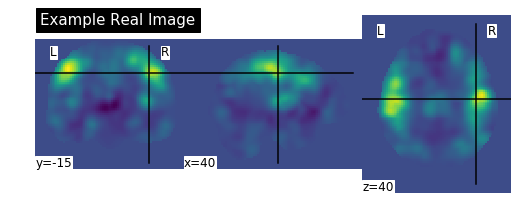

In [11]:
real_im_ex = masker_no_smooth.inverse_transform(real_vbm_data)
x = index_img(real_im_ex,9)
plotting.plot_img(x,title="Example Real Image")

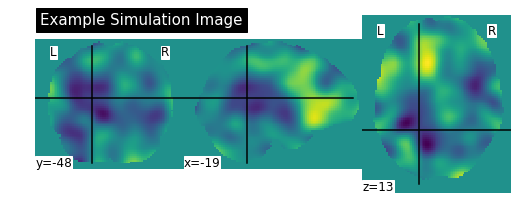

In [12]:
noise_im_func_ex = masker.inverse_transform(noise_im_func)
x = index_img(noise_im_func_ex,1)
plotting.plot_img(x,title="Example Simulation Image")

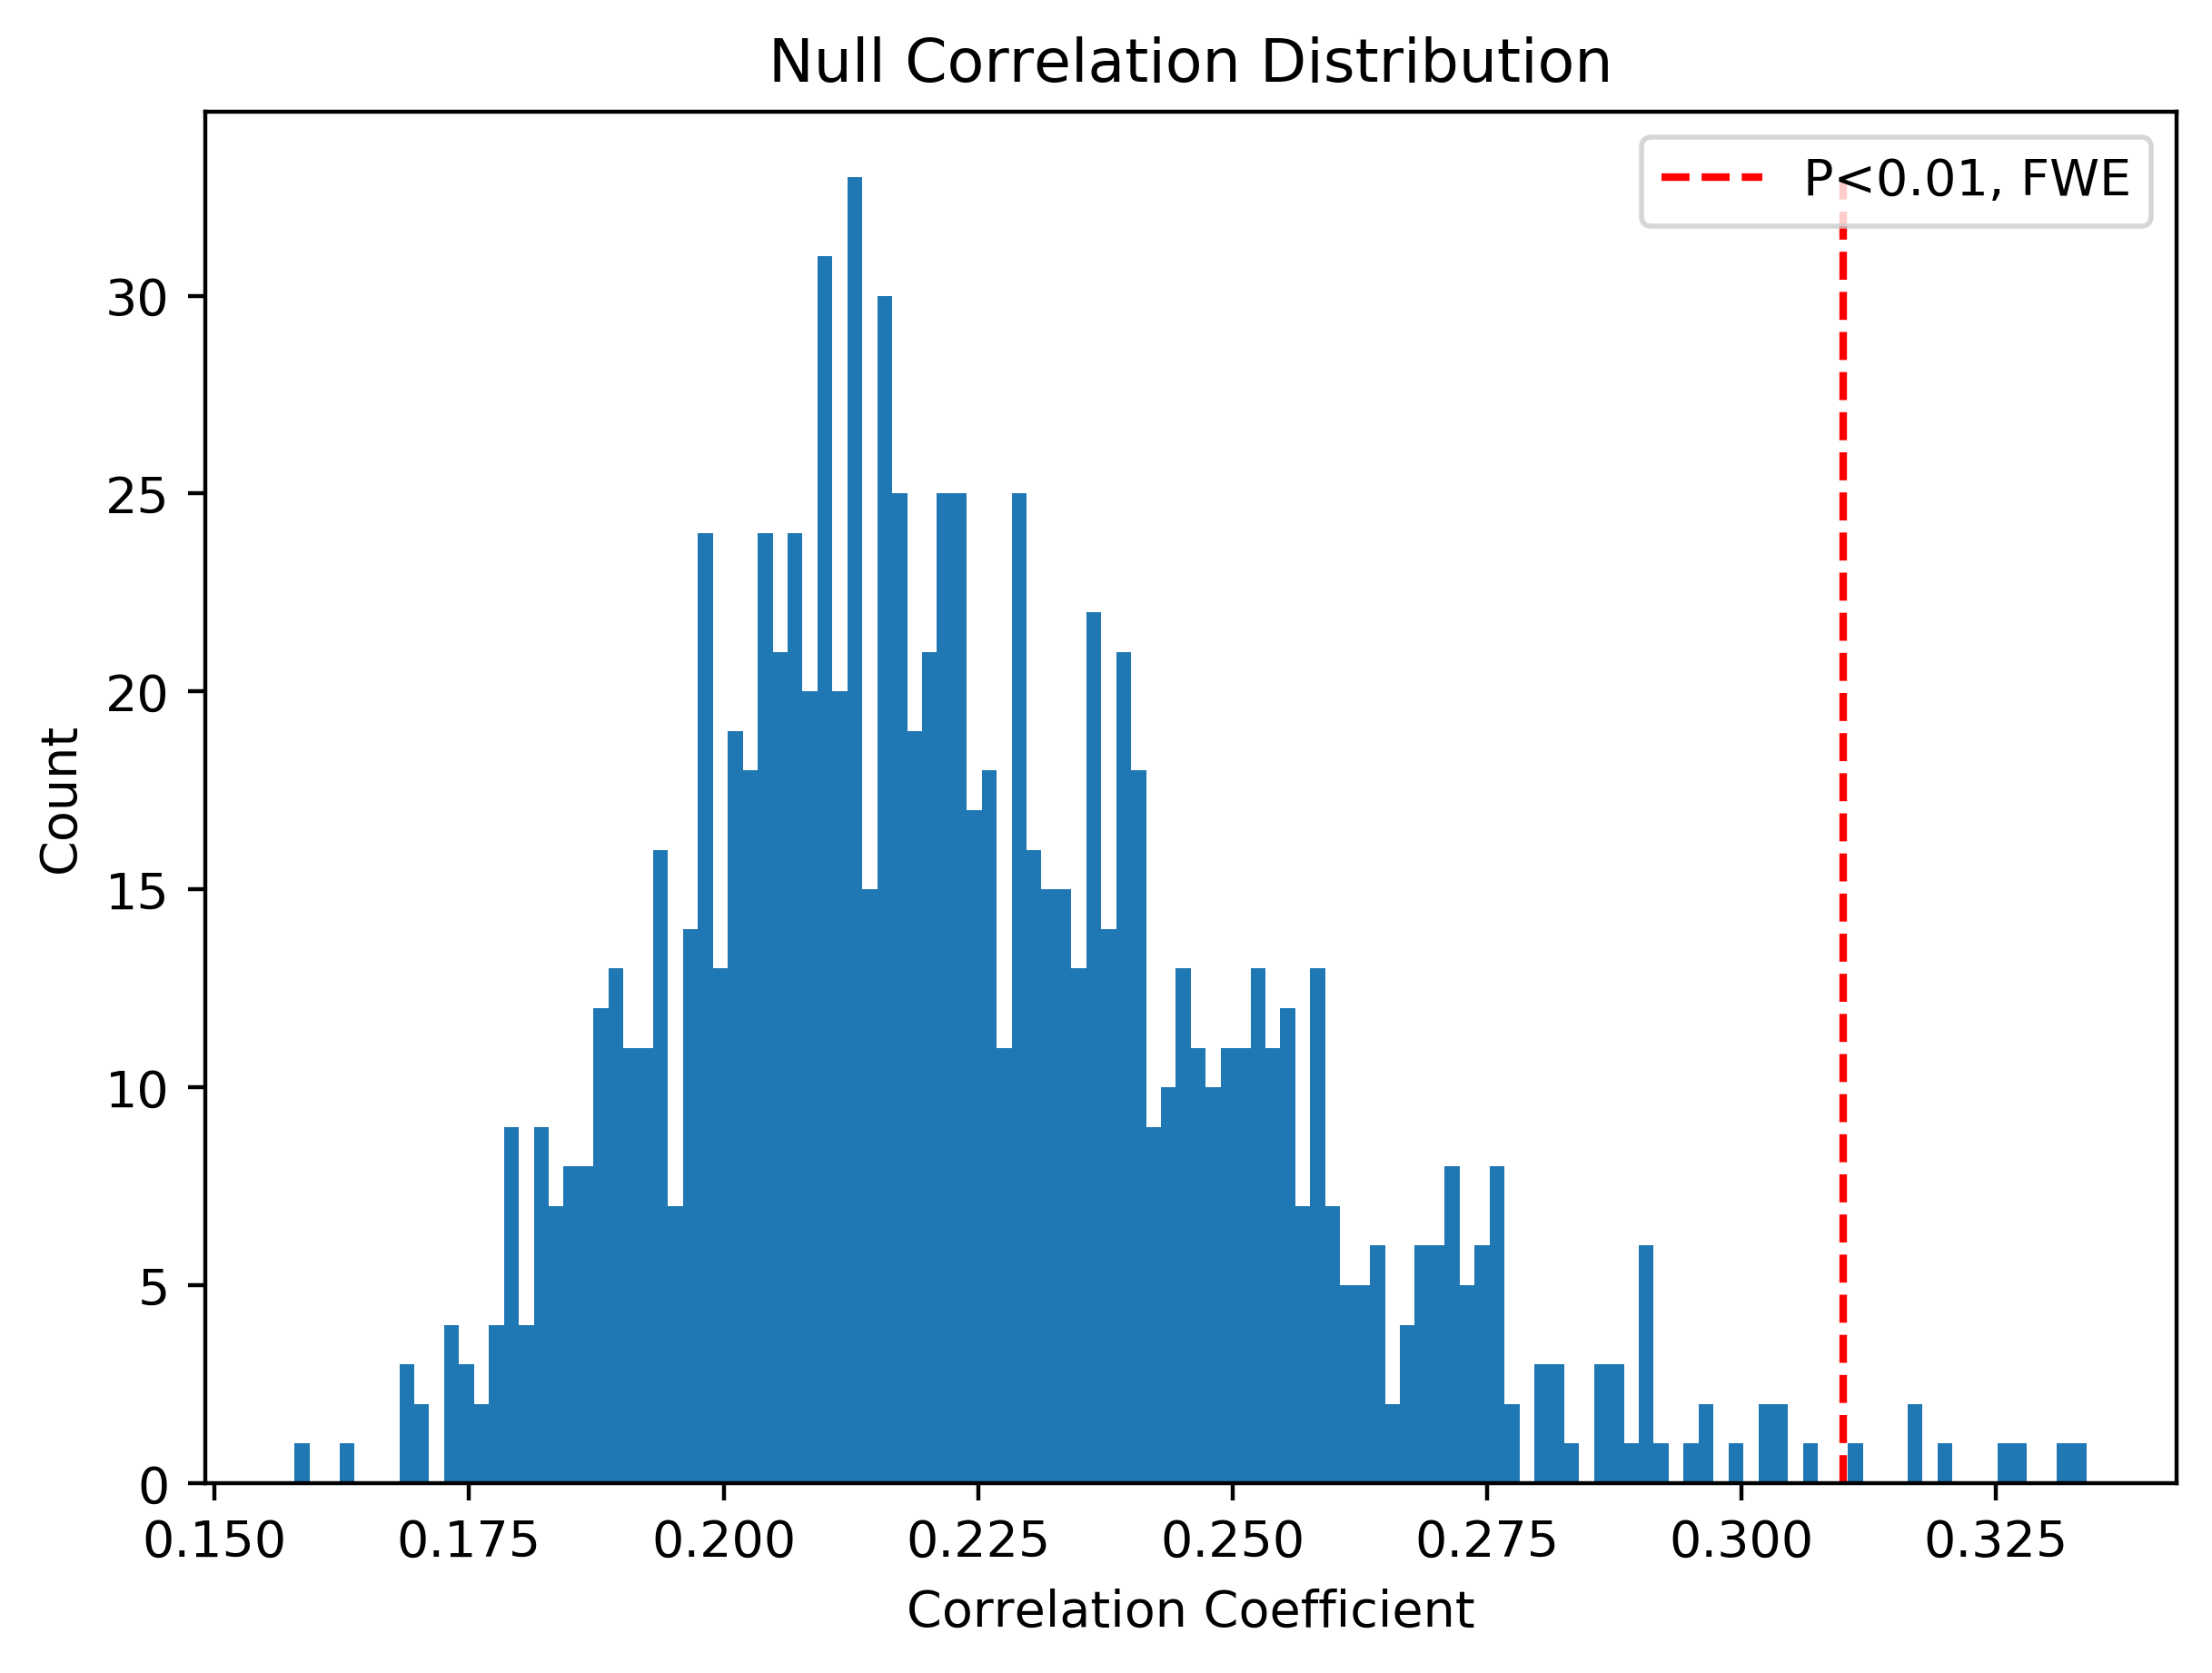

In [14]:
fig = plt.figure(figsize=(7,5),dpi=400)

hist,bins = np.histogram(null_cors,bins=120)
plt.hist(null_cors,bins)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Count')
plt.title('Null Correlation Distribution')
plt.vlines(0.31, ymin=0, ymax=max(hist), color='red', linestyles='dashed', label="P<0.01, FWE")
plt.legend()

plt.savefig('figures/sup_figure_1.png')

In [20]:
# r threshold value
r_threshold = np.percentile(null_cors, 99)
r_threshold

0.30337910247457395

Calculate real correlation matrix of data

In [2]:
functional_ica = load_img("data/FUNCTIONAL_ICA.nii.gz")
vbm_ica = load_img("data/VBM_ICA.nii.gz")

In [3]:
masker_no_smooth = NiftiMasker(mask_img="data/colin_27_mask_2mm_dil.nii.gz")

cor_mat = np.zeros((20,20))

func_im = masker_no_smooth.fit_transform(functional_ica)
vbm_im = masker_no_smooth.fit_transform(vbm_ica)
        
for i in range(0,20):
    for j in range(0,20):
#         if j != 18: #Ignore artifactual component #19, k=18
            cor_mat[i,j] = np.corrcoef(func_im[i,:],vbm_im[j,:])[0,1]

In [4]:
df = pd.DataFrame(data=cor_mat)

df.columns = ['VBM-01','VBM-02','VBM-03','VBM-04','VBM-05','VBM-06','VBM-07','VBM-08','VBM-09','VBM-10','VBM-11','VBM-12','VBM-13','VBM-14','VBM-15','VBM-16','VBM-17','VBM-18','VBM-19-art','VBM-20']

#remove column 19
# df = df.drop(['VBM-19'], axis=1)

df.rename(index={0:'FUNC-01',1:'FUNC-02',2:'FUNC-03',3:'FUNC-04',4:'FUNC-05',5:'FUNC-06',6:'FUNC-07',7:'FUNC-08',8:'FUNC-09',9:'FUNC-10',10:'FUNC-11',11:'FUNC-12',12:'FUNC-13',13:'FUNC-14',14:'FUNC-15',15:'FUNC-16',16:'FUNC-17',17:'FUNC-18',18:'FUNC-19',19:'FUNC-20'}, inplace=True)

#sort by max column/row
df = df.loc[:, df.max().sort_values(ascending=False).index]
maxValuesObj = df.max(axis=1)
maxValuesObj = maxValuesObj.sort_values(ascending=False)
list_max = maxValuesObj.index.tolist()
df = df.loc[list_max,:]

import pickle
df.to_pickle("data/cor_mat.pkl")

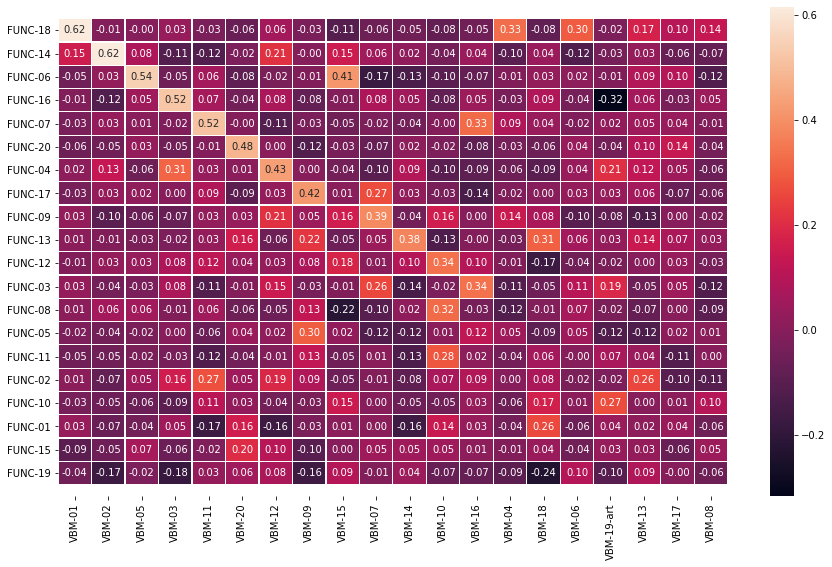

In [5]:
# sns.set(font_scale=1)

fig, ax = plt.subplots(figsize=(15,9))  
ax = sns.heatmap(df, linewidth=0.2, annot=True, fmt=".2f")

#fixes heatmap bug
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

data/dimension_analysis/FUNCTIONAL_ICA_d20.nii.gz
data/dimension_analysis/VBM_ICA_d20.nii.gz
func matches: 17
vbm matches: 17
20
20
vbm matches: [ 0  1  2  2  4  6  8  9  9 10 11 13 14 15 15 17 19]
func matches: [ 2  3  5  5  6  6  7  8 11 12 12 13 15 16 17 17 19]
data/dimension_analysis/vbm372-manual-2002groups_input-4d.ica-d45/melodic_IC.nii.gz
func matches: 23
vbm matches: 23
45
20
data/dimension_analysis/vbm372-manual-2002groups_input-4d.ica-d70/melodic_IC.nii.gz
func matches: 27
vbm matches: 27
70
20
data/dimension_analysis/func549-norm-filtered_int_4d.ica-d45/melodic_IC.nii.gz
data/dimension_analysis/VBM_ICA_d20.nii.gz
func matches: 23
vbm matches: 22
20
45
data/dimension_analysis/vbm372-manual-2002groups_input-4d.ica-d45/melodic_IC.nii.gz
func matches: 37
vbm matches: 37
45
45
vbm matches: [ 0  1  2  2  4  5  6  7  7  7  8 11 13 15 16 18 19 19 20 21 21 22 24 25
 27 28 30 31 31 32 33 33 34 38 40 40 42]
func matches: [ 1  2  3  3  4  5  6  7 10 11 13 13 15 16 16 18 20 21 22 23 23 

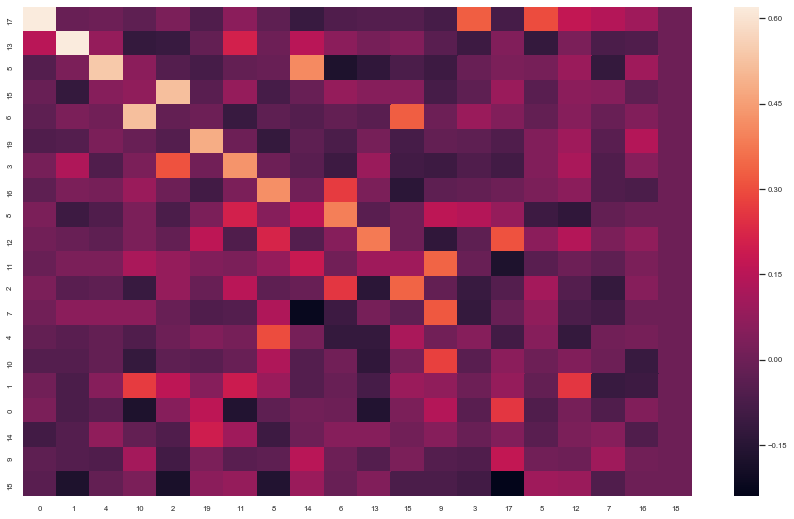

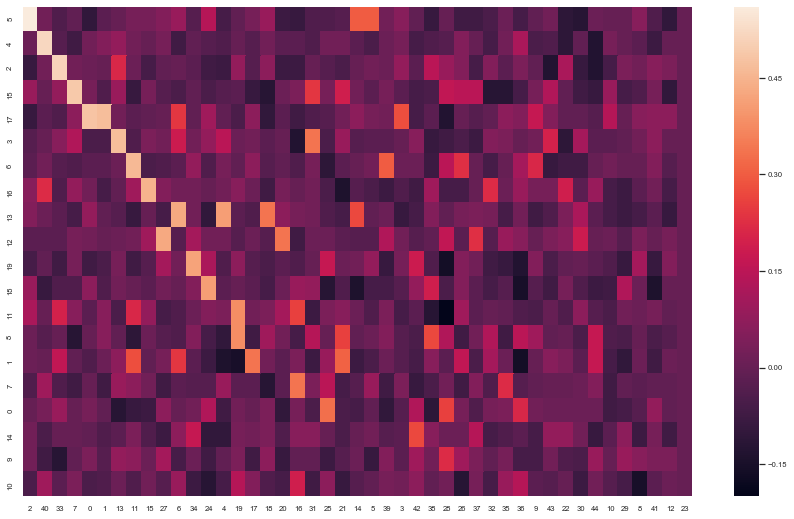

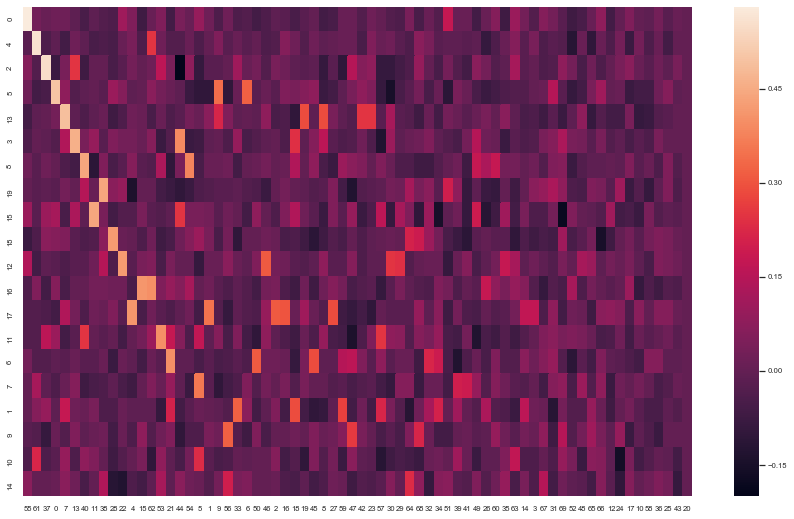

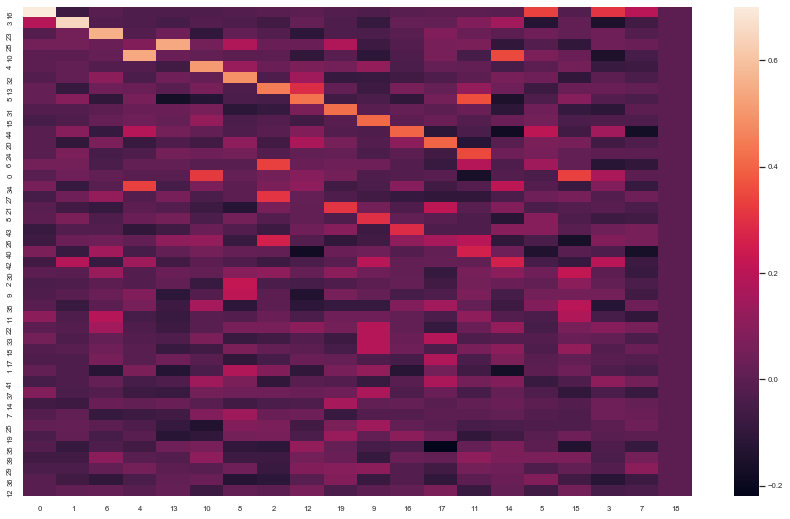

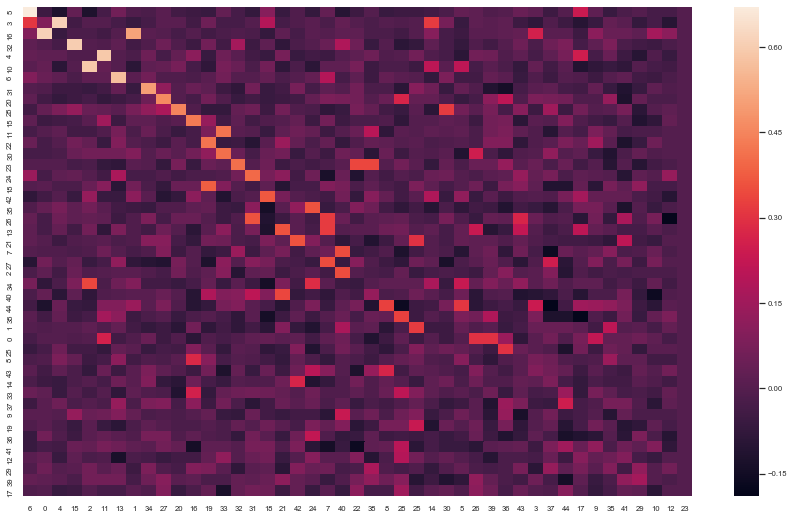

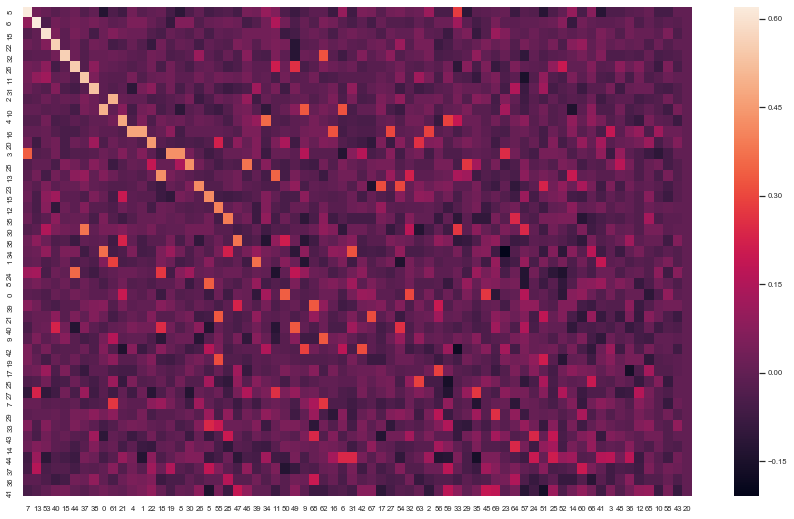

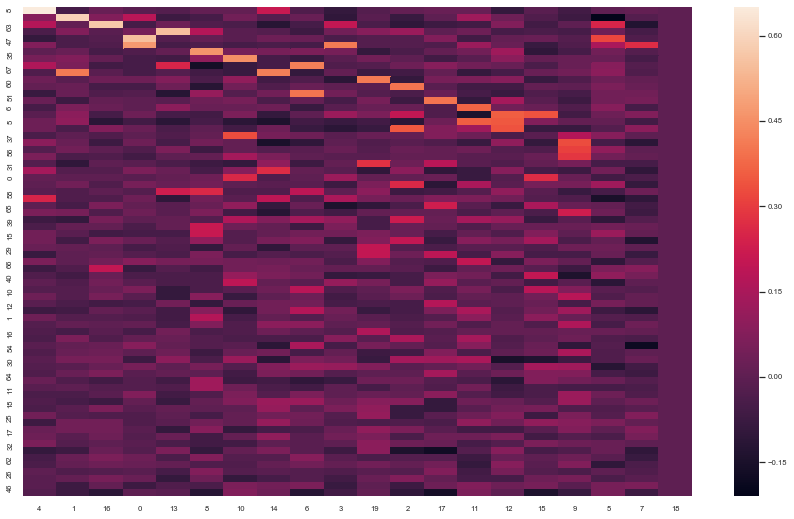

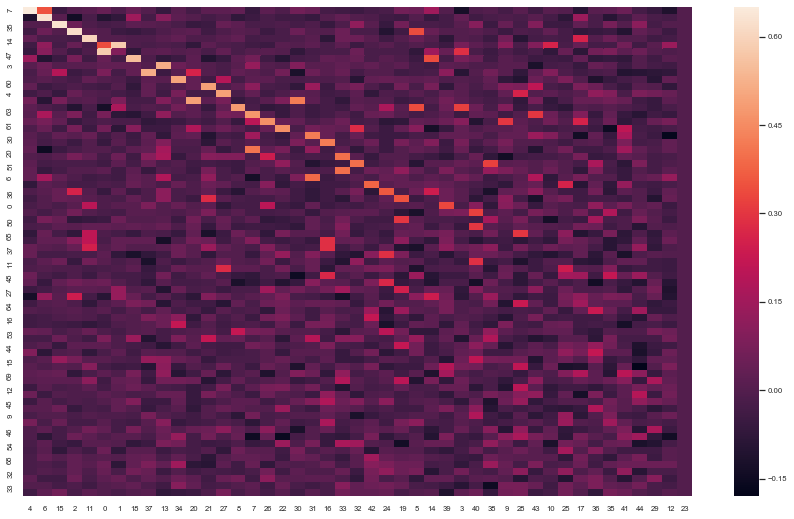

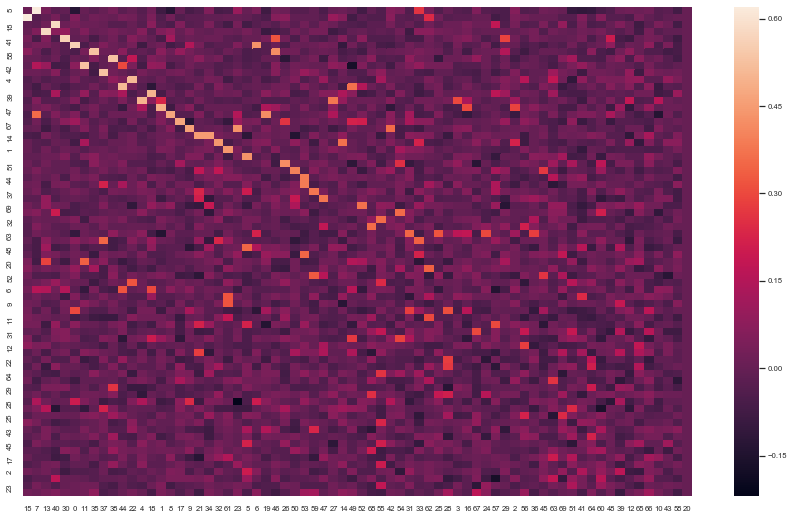

In [17]:
func_data = ["data/dimension_analysis/FUNCTIONAL_ICA_d20.nii.gz",
             "data/dimension_analysis/func549-norm-filtered_int_4d.ica-d45/melodic_IC.nii.gz",
             "data/dimension_analysis/func549-norm-filtered_int_4d.ica-d70/melodic_IC.nii.gz"]
vbm_data = ["data/dimension_analysis/VBM_ICA_d20.nii.gz",
             "data/dimension_analysis/vbm372-manual-2002groups_input-4d.ica-d45/melodic_IC.nii.gz",
             "data/dimension_analysis/vbm372-manual-2002groups_input-4d.ica-d70/melodic_IC.nii.gz"]
d = [20,45,70]

total_matches = np.zeros((len(func_data),len(vbm_data)))
total_unique_matches = np.zeros((len(func_data),len(vbm_data)))

for x in range(0,3):
    print(func_data[x])
    for y in range(0,3): 
        print(vbm_data[y])
        
        func_ica = image.load_img(func_data[x])
        vbm_ica = image.load_img(vbm_data[y])
        
        masker_no_smooth = NiftiMasker(mask_img="data/colin_27_mask_2mm_dil.nii.gz")

        cor_mat = np.zeros((func_ica.shape[3],vbm_ica.shape[3]))

        func_ica = masker_no_smooth.fit_transform(func_ica)
        vbm_ica = masker_no_smooth.fit_transform(vbm_ica)

        corr_above_threshold = []
        corr_above_threshold_vbm = []
        
        func_match_indices = []
        vbm_match_indices = []
        for i in range(0,func_ica.shape[0]):
            vbm_only_matched = 0
            for j in range(0,vbm_ica.shape[0]):
                # artifact components
                if ((vbm_ica.shape[0] == 20) and (j == 18)) or ((vbm_ica.shape[0] == 45) and (j == 23)) or ((vbm_ica.shape[0] == 70) and (j == 20)):
                    cor_mat[i,j] = 0
                else:
                    cor_mat[i,j] = np.around(np.corrcoef(func_ica[i,:],vbm_ica[j,:])[0,1],
                                             decimals=2)
        
        df = pd.DataFrame(data=cor_mat)
    
        threshold = 0.3033
        
        func_matches = 0
        first_match = 0
        for columns in range(0, cor_mat.shape[1]):
            values_indices = cor_mat[:,columns] >= threshold
            values_indices = [i for i, iterator in enumerate(values_indices) if iterator]
            values = list(cor_mat[:,columns][values_indices])
            
            if len(values) > 0:
                # prune low matches (max - min > 0.20)
                while (np.max(values) - np.min(values)) > 0.20:
                    values_indices.pop(int(np.where(values == np.min(values))[0][0]))
                    values.remove(np.min(values))
                    
                func_matches = func_matches + len(values)
                
                if first_match == 0:
                    func_match_indices = np.array(values_indices) # add value_indices
                    first_match = 1
                else:
                    func_match_indices = np.concatenate((func_match_indices, np.array(values_indices))) # add value_indices
                
        print("func matches: " + str(func_matches))
                
        vbm_matches = 0
        first_match = 0
        for rows in range(0, cor_mat.shape[0]):
            values_indices = cor_mat[rows,:] >= threshold
            values_indices = [i for i, iterator in enumerate(values_indices) if iterator]
            values = list(cor_mat[rows,:][values_indices])

            rm = []
            if len(values) > 0:
                # prune low matches
                while (np.max(values) - np.min(values)) > 0.20:
                    
                    values_indices.pop(int(np.where(values == np.min(values))[0][0]))
                    values.remove(np.min(values))
            
                vbm_matches = vbm_matches + len(values)
                
                if first_match == 0:
                    vbm_match_indices = np.array(values_indices) # add value_indices
                    first_match = 1
                else:
                    vbm_match_indices = np.concatenate((vbm_match_indices, 
                                                        np.array(values_indices))) # add value_indices

        print("vbm matches: " + str(vbm_matches))
                
        total_matches[x][y] = (vbm_matches + func_matches)/(np.sum([d[x],d[y]]))*100 
        total_unique_matches[x][y] = (len(np.unique(vbm_match_indices))+len(np.unique(func_match_indices)))/(np.sum([d[x],d[y]]))*100 
        
        # #sort by max column/row
        df = df.loc[:, df.max().sort_values(ascending=False).index]
        maxValuesObj = df.max(axis=1)
        maxValuesObj = maxValuesObj.sort_values(ascending=False)
        list_max = maxValuesObj.index.tolist()
        df = df.loc[list_max,:]
            
        sns.set(font_scale=0.7)
        fig, ax = plt.subplots(figsize=(15,9))  
        ax = sns.heatmap(df)
        
        print(vbm_ica.shape[0])
        print(func_ica.shape[0])
        
        # save match images only when dimensionalities match
        if vbm_ica.shape[0] == func_ica.shape[0]:
            func_ica = image.load_img(func_data[x])
            vbm_ica = image.load_img(vbm_data[y])
            # save vbm matches
            vbm_match_indices.sort()
#             vbm_match_indices = np.unique(vbm_match_indices) # remove duplicates
            vbm_matches = image.index_img(vbm_ica,np.array(vbm_match_indices))
            print("vbm matches: " + str(vbm_match_indices))
            vbm_matches.to_filename('data/dimension_analysis/vbm_' + str(vbm_ica.shape[3]) + "_matches.nii.gz")

            # save func matches
            func_match_indices.sort()
#             func_match_indices = np.unique(func_match_indices)
            func_matches = image.index_img(func_ica,np.array(func_match_indices))
            print("func matches: " + str(func_match_indices))
            func_matches.to_filename('data/dimension_analysis/func_' + str(func_ica.shape[3]) + "_matches.nii.gz")

data/dimension_analysis/func_20_matches.nii.gz


/Users/thomasvanasse/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


data/dimension_analysis/vbm_20_matches.nii.gz
data/dimension_analysis/func_45_matches.nii.gz
data/dimension_analysis/vbm_45_matches.nii.gz
data/dimension_analysis/func_70_matches.nii.gz
data/dimension_analysis/vbm_70_matches.nii.gz


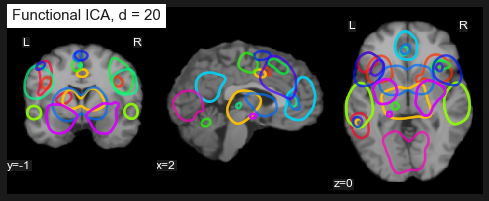

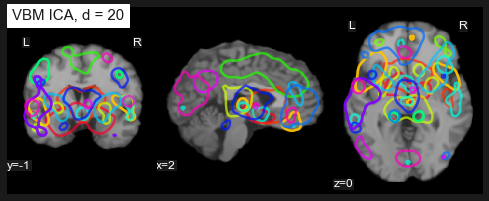

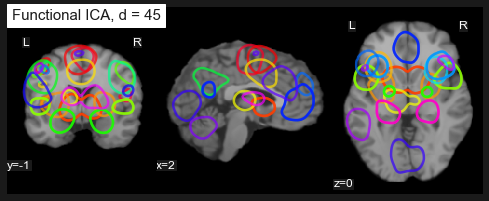

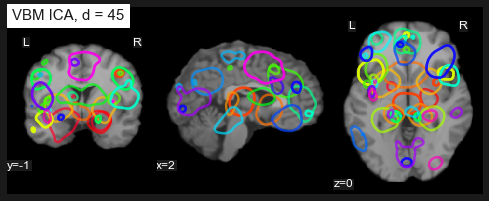

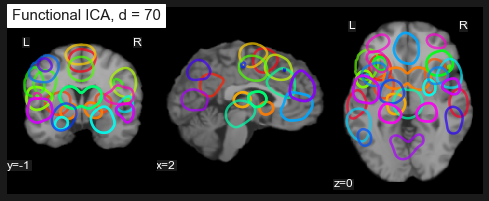

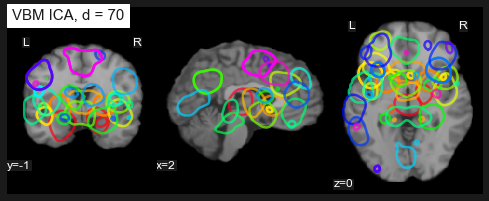

In [3]:
func_data = ["data/dimension_analysis/func_20_matches.nii.gz",
             "data/dimension_analysis/func_45_matches.nii.gz",
             "data/dimension_analysis/func_70_matches.nii.gz"]
vbm_data = ["data/dimension_analysis/vbm_20_matches.nii.gz",
             "data/dimension_analysis/vbm_45_matches.nii.gz",
             "data/dimension_analysis/vbm_70_matches.nii.gz"]

d = [20,45,70]
# d = [20]

for x in range(0,3):
    print(func_data[x])
    plotting.plot_prob_atlas(func_data[x], 
                             view_type='contours',
                             bg_img="data/colin_27.nii.gz",
                             title="Functional ICA, d = " + str(d[x]), 
#                              threshold = 7, 
                             cut_coords=(2,-1,0),
                             draw_cross = False) 
    print(vbm_data[x])
    plotting.plot_prob_atlas(vbm_data[x], 
                             view_type='contours',
                             bg_img="data/colin_27.nii.gz",
                             title="VBM ICA, d = " + str(d[x]), 
#                              threshold = 7, 
                             cut_coords=(2,-1,0),
                             draw_cross = False)

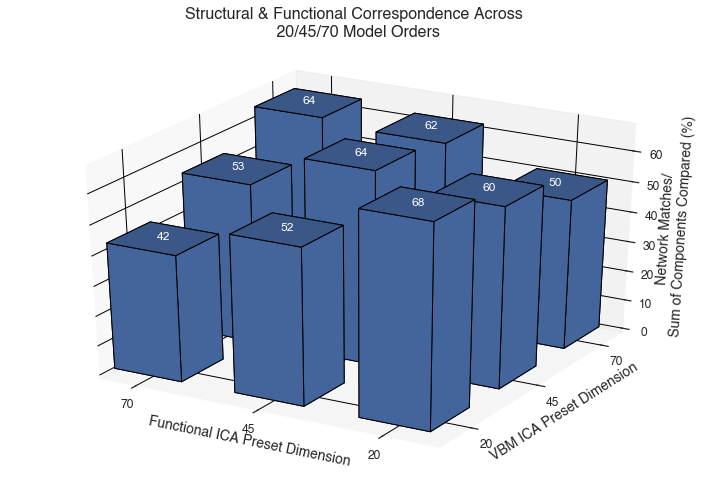

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import pylab as pl

from matplotlib import rc
import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams['ps.useafm'] = True
rc('font',**{'family':'sans-serif','sans-serif':["Times New Roman"]})
plt.rcParams["font.family"] = "Helvetica"


# setup the figure and axes
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

fig.tight_layout()

# set up coordinates to place boxes
_x = [13,38,63]
_y = [13,38,63]
_xx, _yy = np.meshgrid(_x, _y)
x, y = [13, 13, 13, 38, 38, 38, 63, 63, 63], [13, 38, 63, 13, 38, 63, 13, 38, 63]

# top = percent_matches.flatten()
top = total_unique_matches.flatten()
bottom = np.zeros_like(top)
width = depth = 14


ax.set_title('Structural & Functional Correspondence Across \n 20/45/70 Model Orders',
            fontsize=16)

sns.set(font_scale=1)

plt.xticks([20,45,70]) 
plt.yticks([20,45,70]) 

ax.bar3d(x, y, bottom, width, depth, top, shade=True, edgecolor='black')

ax.set_xlim(76, 10)
ax.set_ylim(10,77)
ax.set_facecolor("white")


ax.set_zlabel('Network Matches/ \n Sum of Components Compared (%)', fontsize = 14)
plt.xlabel("Functional ICA Preset Dimension", fontsize = 14)
plt.ylabel("VBM ICA Preset Dimension", fontsize = 14)

plt.rcParams['grid.color'] = "black"


ax.zaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)

# Note that z and y-axis are swapped in the plot.
for x_,y_,z_ in zip(x,y,top):
    ax.text(x_+7,y_+5,z_,'%2.0f'%z_, horizontalalignment='left', verticalalignment='bottom',color="white")
    


plt.subplots_adjust(top=0.88)

plt.savefig('figures/figure_5.png',dpi=600)

plt.show()



In [27]:
# functionl preset dimension (rows)
# vbm preset dimension (columns)
match_dataframe = pd.DataFrame(total_unique_matches, 
                  columns=["VBM_D_20", "VBM_D_45","VBM_D_70"])
match_dataframe["ROWS"] = ["FUNC_D_20", "FUNC_D_45","FUNC_D_70"]
match_dataframe.set_index("ROWS")
match_dataframe.to_csv('data/dimension_analysis/total_unique_matches.csv')